In [1]:
# Python 3.10.6
# Run static type checking with `nbqa mypy oslo.ipynb`
# Run code formatting with `nbqa autopep8 --in-place oslo.ipynb`

import random
import matplotlib.pyplot as plt  # type: ignore
import numpy as np
from time import sleep
from IPython.display import clear_output  # type: ignore

In [110]:
class Model:
    def __init__(self, length: int) -> None:
        """
        Initialise a new Oslo model of a given length
        """
        # min length of 3
        if length < 3:
            raise Exception("Min length is 3")
        self.length: int = length
        # the number of grains at a given location
        self.heights: list[int] = [0] * length
        # the gradient at a given location
        self.gradients: list[int] = [0] * length
        # generate an empty thresholds list
        self.thresholds: list[int] = [0] * length
        # record that the system is in the transient state
        self.is_transient: bool = True
        # randomise each of the new threshold values
        for i in range(length):
            self.new_threshold(i)
        # set plotting interactive mode on
        plt.ion()

    def get_length(self) -> int:
        return self.length

    def get_heights(self) -> list[int]:
        return self.heights

    def get_gradients(self) -> list[int]:
        return self.gradients

    def get_thresholds(self) -> list[int]:
        return self.thresholds

    def get_pile_height(self) -> int:
        return self.heights[0]

    def get_is_transient(self) -> bool:
        return self.is_transient

    def check_index_in_range(self, i: int) -> None:
        """
        Check the index is within the range of the model.
        If not, raise an exception
        """
        # note z_1 has index 0, z_l has index L-1
        if i >= self.length:
            raise Exception("Index out of range")

    def new_threshold(self, i: int) -> None:
        """
        Set a new threshold at position `i`.
        The threshold will be either 1 or 2 with equal chance.
        """
        self.check_index_in_range(i)
        self.thresholds[i] = random.randint(1, 2)

    def drive(self) -> None:
        """
        Add a single grain to the first position
        """
        self.heights[0] += 1
        self.gradients[0] += 1

    def is_supercritical(self, i: int) -> bool:
        """
        Return whether position `i`` is above the threshold
        """
        self.check_index_in_range(i)
        return self.gradients[i] > self.thresholds[i]

    def relax(self, i: int) -> None:
        """
        Relax the  site `i`, assuming it is above the threshold
        """
        self.check_index_in_range(i)
        if i == 0:
            self.heights[i] -= 1
            self.heights[i+1] += 1
            self.gradients[i] -= 2
            self.gradients[i+1] += 1
        elif i == self.length - 1:
            # end relaxation marks the transition to steady state
            if self.is_transient: self.is_transient = False
            self.heights[i] -= 1
            self.gradients[i] -= 1
            self.gradients[i-1] += 1
        else:
            self.heights[i] -= 1
            self.heights[i+1] += 1
            self.gradients[i] -= 2
            self.gradients[i-1] += 1
            self.gradients[i+1] += 1

        # ensure no values are below zero
        if self.heights[i] < 0:
            self.heights[i] = 0
        if self.gradients[i] < 0:
            self.gradients[i] = 0

        self.new_threshold(i)

    def cycle(self) -> None:
        """
        Perform one system cycle of driving and relaxation.
        """
        # add a grain to the first position
        self.drive()
        # relax all positions until stable
        pointer = 0
        while pointer < self.length:
            if self.is_supercritical(pointer):
                self.relax(pointer)
                pointer -= 1
                if pointer < 0:
                    pointer = 0
            else:
                pointer += 1

    def plot(self, sleep_amount=0, clear_screen=True) -> None:
        """
        Show the current state of the system in a graphic
        """
        sleep(sleep_amount)
        if clear_screen: clear_output()
        f = plt.figure()
        f.set_figwidth(3)
        f.set_figheight(6)
        plt.bar(np.array(range(self.length)) + 1, self.heights)
        plt.axis('scaled')
        plt.yticks(range(self.length * 2))
        plt.xticks(np.array(range(self.length)) + 1)
        plt.grid(axis='y')
        plt.show()

### Testing the basic plotting function

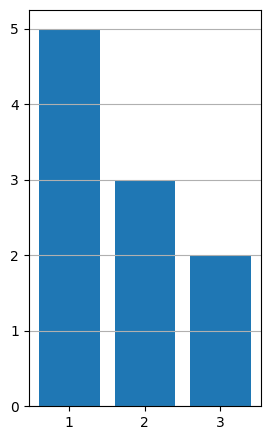

In [84]:
sleep_amount = 0.1

test_model = Model(3)

for i in range(100):
    test_model.plot(sleep_amount)
    test_model.cycle()

### Testing the logic

In [132]:
# measuring transient phase for L16 
test_model = Model(16)
counter = 0
while test_model.get_is_transient():
        test_model.cycle()
        counter += 1
print(counter)

202


In [136]:
# measuring transient phase for L32 
test_model = Model(32)
counter = 0
while test_model.get_is_transient():
        test_model.cycle()
        counter += 1
print(counter)

815


In [126]:
# L16 model should have average height of 26.5

final_heights = []

for i in range(50):
    test_model = Model(16)
    # get to steady state
    while test_model.get_is_transient():
        test_model.cycle()
    # once in steady state run for a set number of trials
    for i in range(1000):
        test_model.cycle()
    final_heights.append(test_model.get_pile_height())

print(np.average(final_heights))

26.52


In [137]:
# L32 model should have average height of 53.9

final_heights = []

for i in range(50):
    test_model = Model(32)
    # get to steady state
    while test_model.get_is_transient():
        test_model.cycle()
    # once in steady state run for a set number of trials
    for i in range(1000):
        test_model.cycle()
    final_heights.append(test_model.get_pile_height())

print(np.average(final_heights))

53.9


### 2a) Height of the Pile

In [138]:
# measuring transient phase for L256, seems to be 50-60k cycles
test_model = Model(256)
counter = 0
while test_model.get_is_transient():
        test_model.cycle()
        counter += 1
print(counter)

56018


In [143]:
heights = []
lengths = [4, 8, 16, 32, 64, 128, 256]
number_cycles = 80000

In [158]:
for length in lengths:
    output = []
    model = Model(length)
    for i in range(number_cycles):
        model.cycle()
        output.append(model.get_pile_height())
    heights.append(output)
    print(length, 'complete')

4 complete
8 complete
16 complete
32 complete
64 complete
128 complete
256 complete


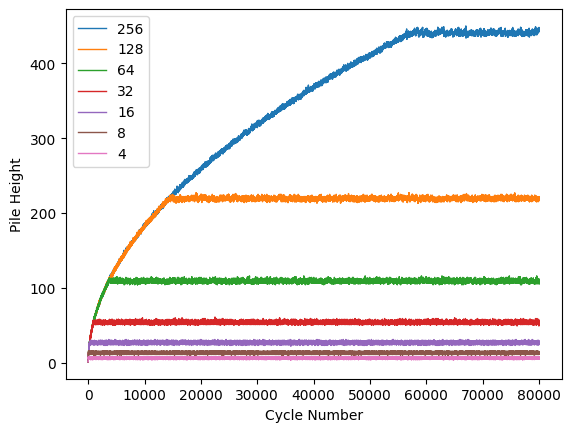

In [181]:
for i in reversed(range(len(lengths))):
    plt.plot(range(number_cycles), heights[i], label=str(lengths[i]), linewidth=1)
plt.legend()
plt.xlabel("Cycle Number")
plt.ylabel("Pile Height")
plt.show()